In [1]:
import cv2
import numpy as np
import imageio
import matplotlib.pyplot as plt
from config import load_config
paths = load_config(dataset_key='all')

Paths are for dataset tagged: all


Z:\smrithi.sunil\data-upload\HSFP_753086_2024-11-11_09-54-29\behavior-videos\side_camera_right.csv


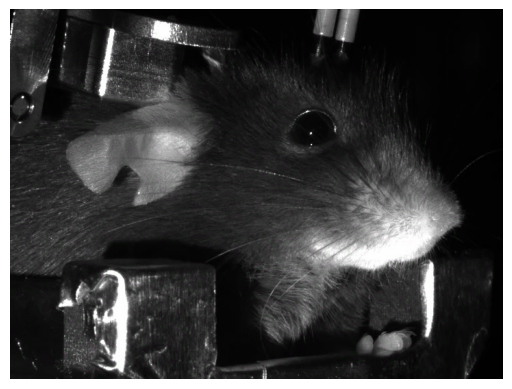

In [2]:
# Load csv of timestamps

# Load behavior timestamps
behavior_time_path = str(paths['raw_data'] / 'behavior-videos\side_camera_right.csv')
timestamps = np.genfromtxt(behavior_time_path, delimiter=',', dtype=None, encoding=None)
behavior_time = timestamps['f0']
print(behavior_time_path)

# Open and check the first frame
video_path = str(paths['raw_data'] / 'behavior-videos\side_camera_right.avi')
reader = imageio.get_reader(video_path, 'ffmpeg')

# Read the first frame
first_frame = reader.get_data(0)

# Display the first frame using matplotlib
plt.imshow(first_frame, vmin=0, vmax=100)
plt.axis('off')
plt.show()

# Close the video reader
reader.close()


Selected ROI - x: 483, y: 236, width: 81, height: 90
Processing frame 0...
Processing frame 1000...
Processing frame 2000...
Processing frame 3000...
Processing frame 4000...
Processing frame 5000...
Processing frame 6000...
Processing frame 7000...
Processing frame 8000...
Processing frame 9000...
Processing frame 10000...
Processing frame 11000...
Processing frame 12000...
Processing frame 13000...
Processing frame 14000...
Processing frame 15000...
Processing frame 16000...
Processing frame 17000...
Processing frame 18000...
Processing frame 19000...
Processing frame 20000...
Processing frame 21000...
Processing frame 22000...
Processing frame 23000...
Processing frame 24000...
Processing frame 25000...
Processing frame 26000...
Processing frame 27000...
Processing frame 28000...
Processing frame 29000...
Processing frame 30000...
Processing frame 31000...
Processing frame 32000...
Processing frame 33000...
Processing frame 34000...
Processing frame 35000...
Processing frame 36000..

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


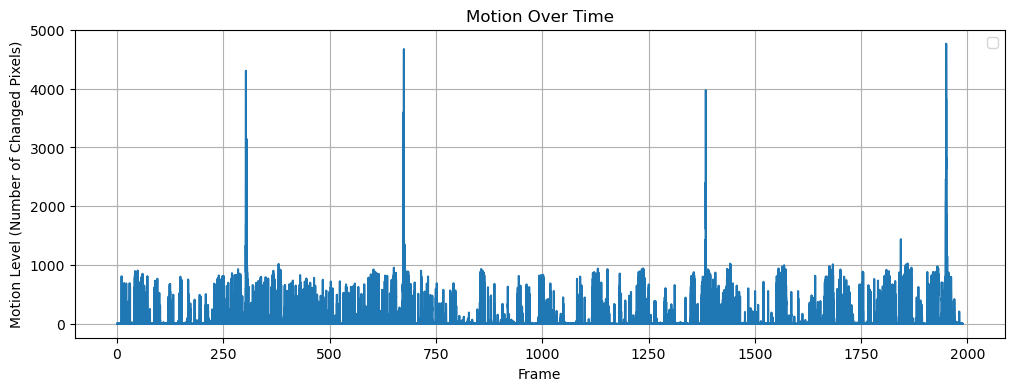

In [3]:
# Select the snout ROI, convert to grayscale, and compute the absolute difference between frames

# Step 1: Open the video file
#video_path = 'C:\AIND\output_data\\750101_2024-11-07_videos\\bottom_camera_new.mp4'

reader = imageio.get_reader(video_path, 'ffmpeg')

# Step 2: Read the first frame
try:
    frame = reader.get_data(0)
except IndexError:
    print("Error: Could not read frame.")
    reader.close()
    exit()

# Convert the frame from RGB (imageio) to BGR (OpenCV)
frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

# Step 3: Display the first frame and let the user select the ROI
roi = cv2.selectROI("Select Snout ROI", frame_bgr, fromCenter=False, showCrosshair=True)
cv2.destroyWindow("Select Snout ROI")

# Extract the ROI coordinates
x, y, w, h = map(int, roi)
print(f"Selected ROI - x: {x}, y: {y}, width: {w}, height: {h}")

# Step 4: Initialize variables for frame differencing
motion_levels = []

# Convert the initial ROI to grayscale
prev_frame = frame[y:y+h, x:x+w]
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_RGB2GRAY)

store = []
# Step 5: Loop through the rest of the frames
frame_count = 1  # We have already read the first frame
for i, frame in enumerate(reader):

    # Print the frame number every 1000 frames
    if i % 1000 == 0:
        print(f"Processing frame {i}...")

    if i == 0:
        continue  # Skip the first frame since we've already processed it
    # if i >= 5000:  # Only use the first 1000 frames
    #     break

    # Extract the current ROI and convert to grayscale
    curr_frame = frame[y:y+h, x:x+w]
    curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_RGB2GRAY)

    # Compute the absolute difference between the current frame and the previous frame
    diff = cv2.absdiff(curr_gray, prev_gray)
    store.append(diff)

    # Threshold the difference image to obtain the motion regions
    threshold_value = 25  # You can adjust this value based on your video
    max_value = 255
    _, thresh = cv2.threshold(diff, threshold_value, max_value, cv2.THRESH_BINARY)

    # Quantify the motion by summing the pixel values
    motion_level = np.sum(thresh) / 255  # Divide by 255 to count the number of white pixels
    # motion_level = np.sum(diff)
    motion_levels.append(motion_level)

    # Update the previous frame
    prev_gray = curr_gray.copy()

    frame_count += 1

    # Optional: Display the current ROI and the thresholded difference
    # curr_frame_bgr = cv2.cvtColor(curr_frame, cv2.COLOR_RGB2BGR)
    # cv2.imshow("Current ROI", curr_frame_bgr)
    # cv2.imshow("Motion", thresh)
    # if cv2.waitKey(1) & 0xFF == ord('q'):
    #     break

# Release the video reader
reader.close()
cv2.destroyAllWindows()

# Step 6: Visualize the motion levels over time
time = behavior_time
plt.figure(figsize=(12, 4))
plt.plot(time-time[0], motion_levels)
plt.xlabel('Frame')
plt.ylabel('Motion Level (Number of Changed Pixels)')
plt.title('Motion Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
# Save the motion levels to a CSV file

output_path = str(paths['raw_data'] / 'fib\whisker_motion.csv')
np.savetxt(output_path, motion_levels, delimiter=',', fmt='%d')
print(f"Motion levels saved to {output_path}")


Motion levels saved to Z:\smrithi.sunil\data-upload\HSFP_753086_2024-11-11_09-54-29\fib\whisker_motion.csv


In [5]:
# # Plot the motion levels over time
# # snout_path = [paths['raw_data'] / 'snout_motion.csv']
# # snout_motion = np.genfromtxt(snout_path[0], delimiter=',', dtype=None, encoding=None)
# whisker_path = [paths['raw_data'] / 'fib\whisker_motion.csv']
# whisker_motion = np.genfromtxt(whisker_path[0], delimiter=',', dtype=None, encoding=None)

# time = behavior_time
# plt.figure(figsize=(12, 4))
# plt.plot((time-time[0]), whisker_motion, label='Whisker Motion')
# # plt.plot((time-time[0]), snout_motion, label='Snout Motion')
# plt.xlabel('Time')
# plt.ylabel('Motion Level')
# plt.xlim(200,300)
# plt.ylim(0,3000)
# plt.show()

In [6]:
# # Load and crop video to desired ROI and save new video

# # Load the video using imageio
# video_path = 'C:\AIND\output_data\\750101_2024-11-07_videos\\bottom_camera.avi'
# output_path = 'C:\AIND\output_data\\750101_2024-11-07_videos\\cropped_video_bottom.avi'

# # Open the video and get frame dimensions and fps
# reader = imageio.get_reader(video_path, 'ffmpeg')
# meta_data = reader.get_meta_data()
# fps = meta_data['fps']
# original_width = meta_data['size'][0]
# original_height = meta_data['size'][1]

# # Extract the first frame to use for ROI selection
# first_frame = reader.get_data(0)

# # Display the first frame and select the ROI
# first_frame_bgr = cv2.cvtColor(first_frame, cv2.COLOR_RGB2BGR)  # Convert to BGR for OpenCV
# roi = cv2.selectROI("Select ROI", first_frame_bgr, fromCenter=False, showCrosshair=True)
# cv2.destroyWindow("Select ROI")

# # Get ROI coordinates
# x, y, width, height = roi
# print(f"Selected ROI - X: {x}, Y: {y}, Width: {width}, Height: {height}")

# # Set up the output writer with the new cropped dimensions
# fourcc = cv2.VideoWriter_fourcc(*'MJPG')  # Choose codec (e.g., 'XVID' for .avi)
# writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# # Process only the first 10 frames, crop each, and write to the output video
# for frame in reader:

#     # Convert the frame to BGR format for OpenCV compatibility
#     frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

#     # Crop the frame to the selected ROI
#     cropped_frame = frame_bgr[y:y+height, x:x+width]

#     # Write the cropped frame to the output file
#     writer.write(cropped_frame)

# # Release the video writer and close the imageio reader
# writer.release()
# reader.close()

# print("Cropped video test saved as", output_path)